# Kalman Filter Parameter Optimization using Genetic Algorithm

In [1]:
# imports
import numpy as np
from deap import base, creator, tools, algorithms
from KalmanFilter import KalmanFilter
from SignalGenerator import SignalGenerator
import matplotlib.pyplot as plt
import random
import multiprocessing
from scoop import futures

In [2]:
# Define the evaluation function
def evaluate(individual):
    f_val, h_val, q_val, r_val = individual
    F = np.array([[f_val]])
    H = np.array([[h_val]])
    Q = np.array([[q_val]])
    R = np.array([[r_val]])
    P = np.array([[0]])
    x = np.array([[0]])

    # Add noise to create noisy measurement
    noise_std = 0.5
    noisy_signal = SigGen.add_noise(true_signal, noise_std)
    kf = KalmanFilter(F, H, Q, R, P, x)
    filtered_signal = kf.filter(noisy_signal)
    _, rmse = kf.calculate_error(true_signal, filtered_signal)
    return rmse,

In [3]:
def select_with_elitism_and_diversity(population, n, halloffame, random_count=2, tournsize=3):
    """
    Selects individuals for the next generation by combining elitism, tournament
    selection, and random sampling.

    Parameters:
    -----------
    population : list
        A list of individuals from which to select.
    n : int
        The number of individuals to select.
    halloffame : HallOfFame
        The hall of fame containing the best individuals.
    random_count : int, optional
        The number of random individuals to add for diversity.
    tournsize : int, optional
        The tournament size for selection.

    Returns:
    --------
    list
        A new list of individuals for the next generation, containing the
        best individuals from the hall of fame, the winners of the
        tournament selection, and a few random individuals.
    """
    # Number of elite individuals to preserve
    elite_count = len(halloffame)
    # First, use an existing selection (tournament) to choose the rest
    selected = tools.selTournament(population, n - elite_count - random_count, tournsize)
    # Then, merge the *halloffame* individuals
    selected.extend(halloffame)
    # Add a few random individuals
    for _ in range(random_count):
        selected.append(toolbox.individual())
    return selected

In [4]:
def evolve_with_elitism(pop, cxpb, mutpb, ngen, toolbox):
    """
    Executes a genetic algorithm with elitism, where the best individual is
    preserved between generations.

    Parameters:
    -----------
    pop : list
        A list of individuals representing the population.
    cxpb : float
        The probability of mating two individuals (crossover probability).
    mutpb : float
        The probability of mutating an individual.
    ngen : int
        The number of generations to evolve.
    toolbox : Toolbox
        A DEAP toolbox containing the genetic operators.

    Notes:
    ------
    This function implements a custom evolutionary algorithm that:
    1. Evaluates all individuals in each generation
    2. Preserves the best individual (elitism)
    3. Selects individuals for the next generation
    4. Applies crossover and mutation based on the given probabilities
    5. Adds the elite individual to the offspring
    6. Replaces the population with the new generation

    The toolbox should contain registered functions for:
    - evaluate: to compute fitness values
    - select: to select individuals for reproduction
    - mate: for crossover between individuals
    - mutate: to introduce variation
    - clone: to create copies of individuals
    """
    for gen in range(ngen):
        # Evaluate all individuals
        for ind in pop:
            ind.fitness.values = toolbox.evaluate(ind)

        # Apply elitism: Find the best individual
        best_ind = tools.selBest(pop, k=1)[0]

        # Select the next generation
        offspring = toolbox.select(pop, len(pop) - 1)
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation to offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Add the elite individual to the next generation
        offspring.append(toolbox.clone(best_ind))

        pop[:] = offspring  # Replace the current population with the new generation

# Create a synthetic signal

In [5]:
# Signal parameters
frequency = 480  # Hz
sampling_rate = 20000  # Hz
duration = 0.2  # seconds (200 ms)
amplitude = 0.1
offset = 0.1

SigGen = SignalGenerator(frequency, sampling_rate, duration, amplitude)

# Generate a clean 400 Hz sine wave
true_signal = SigGen.generate_signal('square')
true_signal = SigGen.add_offset(true_signal, offset)

# Add noise to create noisy measurement
noise_std = 0.5
noisy_signal = SigGen.add_noise(true_signal, noise_std)

# Get time vector
t= SigGen.get_time()

# Plot the original, noisy, and filtered signals

MSE: 0.0547234614698499
RMSE: 0.2339304628941043


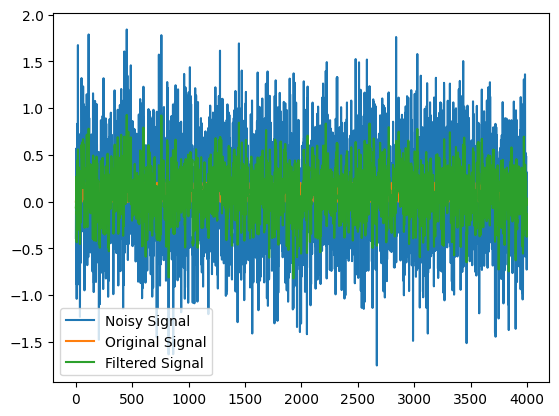

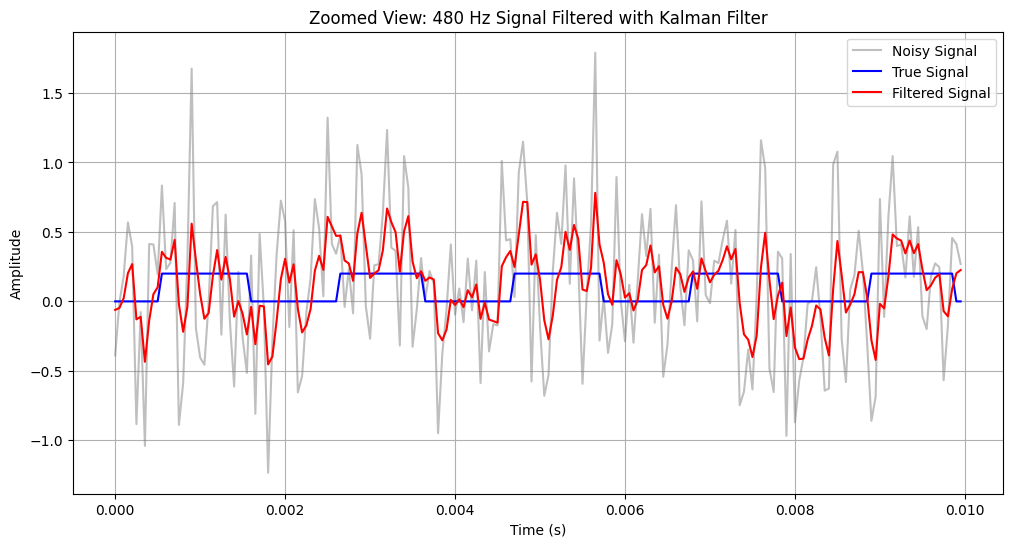

In [6]:
# Initialize Kalman filter
F = np.array([[1]])
H = np.array([[1]])
Q = np.array([[18.679136]])
R = np.array([[100]])
P = np.array([[0]])
x = np.array([[0]])

# Create and apply filter
kf = KalmanFilter(F, H, Q, R, P, x)
filtered_signal = kf.filter(noisy_signal)

# Calculate error metrics
mse, rmse = kf.calculate_error(true_signal, filtered_signal)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Plot results
kf.plot_results(noisy_signal, true_signal, filtered_signal)

# Zoom in to show detail
plt.figure(figsize=(12, 6))
zoom_samples = int(0.01 * sampling_rate)  # Show 10ms
plt.plot(t[:zoom_samples], noisy_signal[:zoom_samples], 'gray', alpha=0.5, label='Noisy Signal')
plt.plot(t[:zoom_samples], true_signal[:zoom_samples], 'b', label='True Signal')
plt.plot(t[:zoom_samples], filtered_signal[:zoom_samples], 'r', label='Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Zoomed View: 480 Hz Signal Filtered with Kalman Filter')
plt.legend()
plt.grid(True)
plt.show()

# Implementing the Genetic Algorithm

In [7]:
# Genetic Algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize the RMSE
creator.create("Individual", list, fitness=creator.FitnessMin)  # Create individuals as lists
# Create the toolbox for genetic operations
toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, 1e-9, 5e3) # Random float for F, H, Q and R in the range [1e-6, 1e3]
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=4) # Each individual has four parameters: F, H, Q and R
toolbox.register("population", tools.initRepeat, list, toolbox.individual) # Create the genetic operations

toolbox.register("mate", tools.cxBlend, alpha=0.5) # Blend crossover
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2) # Gaussian mutation
#toolbox.register("select", tools.selTournament, tournsize=3) # Default Tournament selection
toolbox.register("evaluate", evaluate) # Evaluation function to calculate RMSE for each individual
# Use elitism to preserve the best individuals
#toolbox.register("select", tools.selBest)
# Enable parallel processing
#toolbox.register("map", futures.map)
#pool = multiprocessing.Pool()
#toolbox.register("map", pool.map)

In [8]:
# Run the genetic algorithm
popsize = 300 # Population size
ngen = 1000  # Number of generations
cxpb = 0.75  # Crossover probability
mutpb = 0.4 # Mutation probability
halloffame = tools.HallOfFame(5)  # Preserve the best individual
# Register the custom selection method to include elitism
toolbox.register("select", select_with_elitism_and_diversity, halloffame=halloffame, random_count=10)
population = toolbox.population(n=popsize) # Population size

# Statistics to keep track of the progress
stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values)
stats_size = tools.Statistics(key=len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# Run the genetic algorithm
lastPob, logbook = algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=mstats, halloffame=halloffame, verbose=True)


   	      	                         fitness                         	                    size                   
   	      	---------------------------------------------------------	-------------------------------------------
gen	nevals	avg    	gen	max     	min    	nevals	std      	avg	gen	max	min	nevals	std
0  	300   	0.14191	0  	0.508496	0.13506	300   	0.0212049	4  	0  	4  	4  	300   	0  
1  	273   	0.140712	1  	0.161961	0.136747	273   	0.00157774	4  	1  	4  	4  	273   	0  
2  	244   	0.141833	2  	0.4451  	0.13506 	244   	0.0194298 	4  	2  	4  	4  	244   	0  
3  	260   	0.147286	3  	1.3716  	0.13506 	260   	0.0854585 	4  	3  	4  	4  	260   	0  
4  	256   	0.146669	4  	1.44744 	0.13431 	256   	0.088418  	4  	4  	4  	4  	256   	0  
5  	261   	0.150647	5  	2.55801 	0.13431 	261   	0.148624  	4  	5  	4  	4  	261   	0  
6  	244   	0.13815 	6  	0.31277 	0.1338  	244   	0.0111513 	4  	6  	4  	4  	244   	0  
7  	263   	0.13642 	7  	0.146935	0.134091	263   	0.00128497	4  	7  	4  	4  	263   	0

KeyboardInterrupt: 

In [9]:
# Close the pool
#pool.close()
#pool.join()

In [10]:
#record = mstats.compile(lastPob)
#res_logbook = org_logbook.copy() #   tools.Logbook()
#res_logbook.record(**record)

#res_logbook.header = "gen", "evals", "fitness", "size"
#res_logbook.chapters["fitness"].header = "min", "avg", "max"
#res_logbook.chapters["size"].header = "min", "avg", "max"

#print(res_logbook)

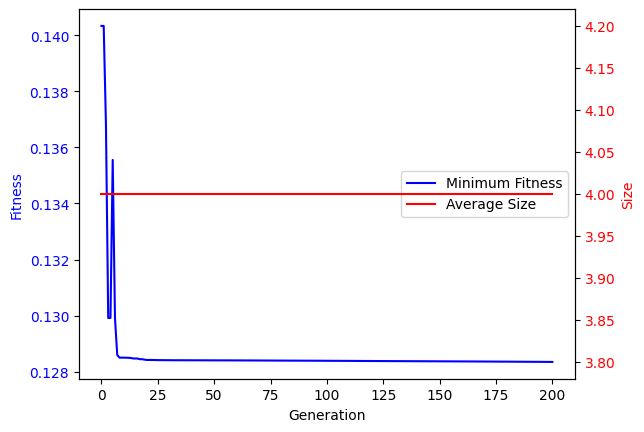

In [11]:
gen = logbook.select("gen")
fit_mins = logbook.chapters["fitness"].select("min")
size_avgs = logbook.chapters["size"].select("avg")

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

ax2 = ax1.twinx()
line2 = ax2.plot(gen, size_avgs, "r-", label="Average Size")
ax2.set_ylabel("Size", color="r")
for tl in ax2.get_yticklabels():
    tl.set_color("r")

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center right")

plt.show()

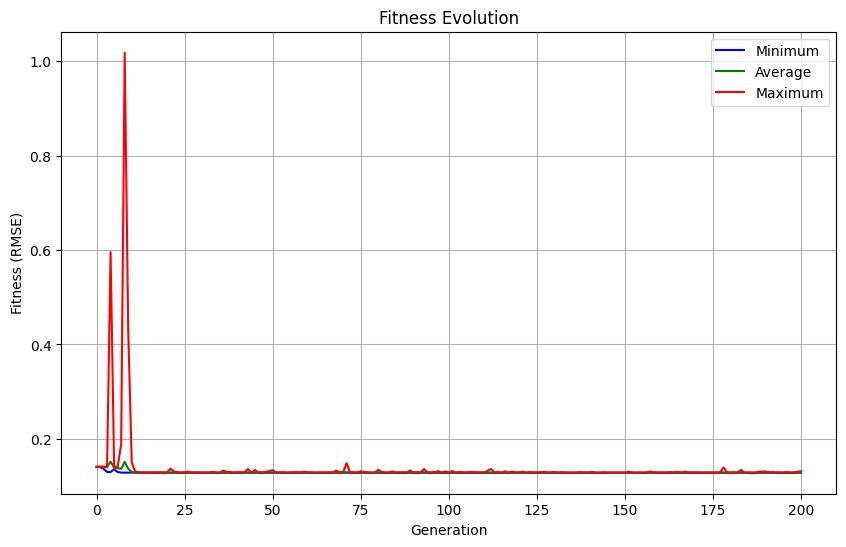

In [12]:
# Plot min, avg, max fitness over generations
plt.figure(figsize=(10, 6))
plt.plot(logbook.select("gen"), logbook.chapters["fitness"].select("min"), 'b-', label='Minimum')
plt.plot(logbook.select("gen"), logbook.chapters["fitness"].select("avg"), 'g-', label='Average')
plt.plot(logbook.select("gen"), logbook.chapters["fitness"].select("max"), 'r-', label='Maximum')
plt.xlabel('Generation')
plt.ylabel('Fitness (RMSE)')
plt.title('Fitness Evolution')
plt.legend()
plt.grid(True)
plt.show()

# Extract the best individual

In [13]:
print(f"\n============  Hall Of Fame ==============\n")
# best_individual = tools.selBest(population, k=1)[0]
best_individual = halloffame[0]
best_f, best_h, best_q, best_r = best_individual
best_fitness = float(best_individual.fitness.values[0])
print("Best Individual:")
print(f"Individual: {best_individual}")
print(f"Best F: {best_f}, Best H: {best_h}, Best Q: {best_q}, Best R: {best_r}, Fitness: {best_fitness}")

print("\nNext Best Individuals:")
for individual in halloffame[1:]:
    f,h,q, r = individual
    fitness = float(individual.fitness.values[0])
    print(f"F: {f}, H: {h}, Q: {q}, R: {r}, Fitness: {fitness}")

print(f"\n===== Best Individual Performance =====\n")

# Create filter with optimal parameters
optimal_F = np.array([[best_f]])
optimal_H = np.array([[best_h]])
optimal_Q = np.array([[best_q]])
optimal_R = np.array([[best_r]])
P = np.array([[0]])
x = np.array([[0]])
optimal_kf = KalmanFilter(optimal_F, optimal_H, optimal_Q, optimal_R, P, x)
optimal_filtered = optimal_kf.filter(noisy_signal)

# Calculate improvement over original parameters
original_mse, original_rmse = kf.calculate_error(true_signal, filtered_signal)
optimal_mse, optimal_rmse = kf.calculate_error(true_signal, optimal_filtered)
improvement = ((original_rmse - optimal_rmse) / original_rmse) * 100

print(f"Original RMSE: {original_rmse:.6f}")
print(f"Optimal RMSE: {optimal_rmse:.6f}")
print(f"Improvement: {improvement:.2f}%")

print(f"\n=======================================\n")



============  Hall Of Fame ==============

Best Individual:
Individual: [132.868287845949, 5.721277677729301, 1413.6759767785006, 3001.9274286590608]
Best F: 132.868287845949, Best H: 5.721277677729301, Best Q: 1413.6759767785006, Best R: 3001.9274286590608, Fitness: 0.12834372986680204

Next Best Individuals:
F: 133.01522817306812, H: 5.721273741539491, Q: 1410.966807020075, R: 3001.3696511057387, Fitness: 0.12834390157635187
F: 133.07115601583934, H: 5.721274350021095, Q: 1413.1071774454706, R: 3001.9965973432963, Fitness: 0.12834396710900264
F: 133.07938122426705, H: 5.721276348646683, Q: 1413.1561881364505, R: 3001.5524336135486, Fitness: 0.12834397675033035
F: 133.1210223280929, H: 5.721277782456919, Q: 1412.211052353698, R: 3001.4200606431173, Fitness: 0.12834402528943015

===== Best Individual Performance =====

Original RMSE: 0.141045
Optimal RMSE: 0.128344
Improvement: 9.00%




# Test The Kalman Filter with the best parameters

MSE: 0.013711475406318197
RMSE: 0.11709600935265982


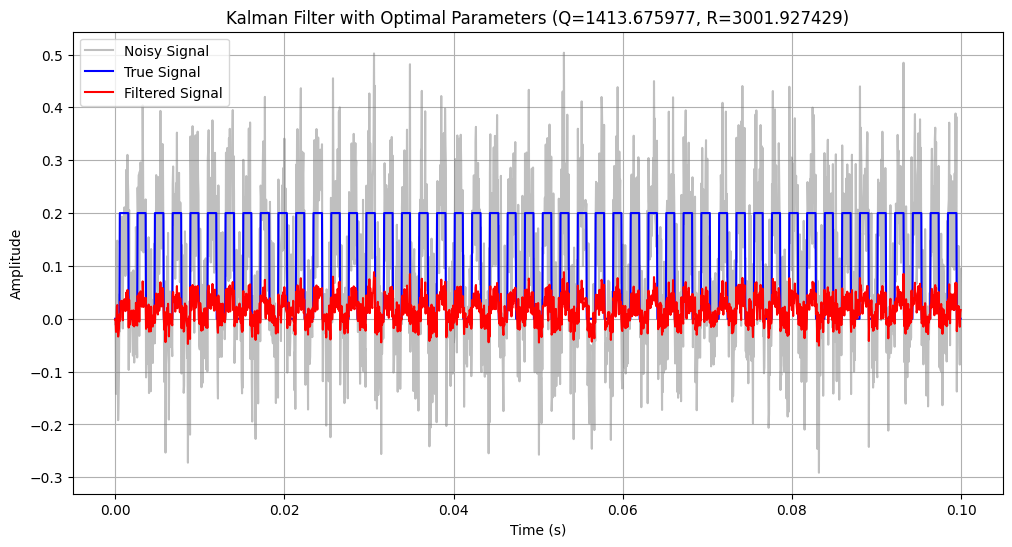

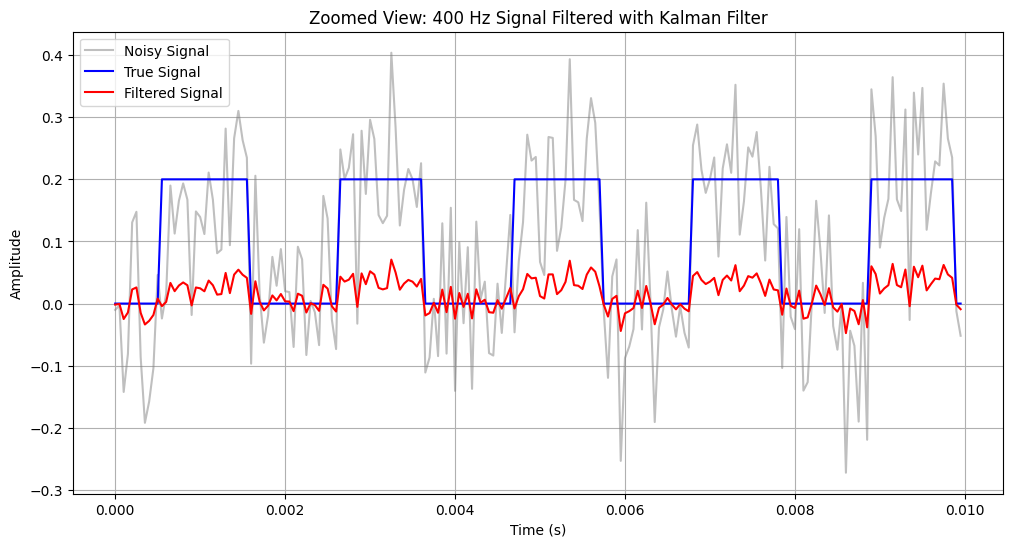

In [14]:
# Add noise to create noisy measurement
noise_std = 0.1
noisy_signal = SigGen.add_noise(true_signal, noise_std)

# Initialize Kalman filter
optimal_F = np.array([[best_f]])
optimal_H = np.array([[best_h]])
optimal_Q = np.array([[best_q]])
optimal_R = np.array([[best_r]])
P = np.array([[0]])  #
x = np.array([[0]])

# Create and apply filter
kf = KalmanFilter(optimal_F, optimal_H, optimal_Q, optimal_R, P, x)
filtered_signal = kf.filter(noisy_signal)

# Calculate error metrics
mse, rmse = kf.calculate_error(true_signal, filtered_signal)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(t, noisy_signal, 'gray', alpha=0.5, label='Noisy Signal')
plt.plot(t, true_signal, 'b', label='True Signal')
plt.plot(t, filtered_signal, 'r', label='Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Kalman Filter with Optimal Parameters (Q={best_q:.6f}, R={best_r:.6f})')
plt.legend()
plt.grid(True)

# Zoom in to show detail
plt.figure(figsize=(12, 6))
zoom_samples = int(0.01 * sampling_rate)  # Show 10ms
plt.plot(t[:zoom_samples], noisy_signal[:zoom_samples], 'gray', alpha=0.5, label='Noisy Signal')
plt.plot(t[:zoom_samples], true_signal[:zoom_samples], 'b', label='True Signal')
plt.plot(t[:zoom_samples], filtered_signal[:zoom_samples], 'r', label='Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Zoomed View: 400 Hz Signal Filtered with Kalman Filter')
plt.legend()
plt.grid(True)
plt.show()